# <center>Analyser les ventes d'une librairie avec Python

**Scénario :**<p>
Vous êtes consultant Data Analyst chez Lapage, une grande librairie généraliste en ligne très réputée. Vous êtes directement rattaché au service Marketing.<p>
Vous intervenez car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

---

**Compétences évaluées :**<p>

- Réaliser une analyse bivariée pour interpréter des données :<p>
    - analyse des différents indicateurs de ventes<p>
    - répartition du chiffre d'affaires entre les clients, via une courbe de Lorenz<p>
- Analyser des séries temporelles :<p>
    - évolution du chiffre d'affaires dans le temps et décomposition en moyenne mobile pour évaluer la tendance globale<p>
- Réaliser un test statistique :<p>
    - utiliser une ANOVA et un test de  kruskal-wallis sur une variable quantitative et une qualitative<p>
    - utiliser une corrélation de Spearman et de Pearson sur deux variables quantitatives <p>
    - utiliser un test de Chi2 sur deux variables qualitatives

---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import datetime as dt

#### Fichier client

In [2]:
client = pd.read_csv('customers.csv')

In [3]:
client.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [5]:
client.describe(include="all")

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_1807,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


tous les client_id sont unique
il n'y a que 2 sex
les dates de naissances sont comprise entre 1929 et 2004 => a priori pas d'erreur

In [6]:
#Création d'un colonne age
client['age'] = 2021-client.birth

In [7]:
#Vérification des données manquantes
client.isna().mean()*100

client_id    0.0
sex          0.0
birth        0.0
age          0.0
dtype: float64

In [8]:
# création d'une fonction pour la recherche de doublons

def check_possible_primary_key(df, columns_pk):
    if len(df) != len(df[columns_pk].drop_duplicates()):
        raise Exception("{} can't be a primary key!".format(columns_pk))
    else :
        print("{} is a possible primary key!".format(columns_pk))

In [9]:
check_possible_primary_key(client,"client_id")

client_id is a possible primary key!


#### Fichier produit

In [10]:
produit = pd.read_csv('products.csv')

In [11]:
produit.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [12]:
produit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [13]:
produit.describe(include="all")

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,1_166,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


>il y a 3287 lignes dans le fichier

>pas de données manquantes

>tous les id_prod sont uniques => pas de doublons

>il y a des prix negatif , avec une moyenne a 21.85 et 75% des valeurs a 22.99

In [14]:
# Vérification du prix min
produit[produit['price'] == -1]

,id_prod,price,categ
731,T_0,-1.0,0


In [15]:
# Selection de tous les prix qui ne sont pas egale a -1
produit = produit[produit['price'] != -1]

In [16]:
## Vérification du prix max
produit[produit['price'] == 300]

,id_prod,price,categ
947,2_2,300.0,2


In [17]:
#Vérification si valeurs manquantes
produit.isna().mean()*100

id_prod    0.0
price      0.0
categ      0.0
dtype: float64

In [18]:
check_possible_primary_key(produit,"id_prod")

id_prod is a possible primary key!


#### Fichier transaction

In [19]:
transaction = pd.read_csv('transactions.csv')

In [20]:
transaction.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [21]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [22]:
transaction.describe(include="all")

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


- il y a 3267 valeurs uniques dans le fichier transaction et 3287 dans le fichier produit
- il y du texte "test" dans les dates
- il faut convertir le type de la colonne date objet=>date
- verifier la session "s_0" => possible session "test"
- il y a 8602 clients uniques


In [23]:
#Vérification si données manquantes
transaction.isna().mean()*100

id_prod       0.0
date          0.0
session_id    0.0
client_id     0.0
dtype: float64

In [24]:
#Vérification de la session "s_0"
transaction[transaction['session_id'] == "s_0"]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [25]:
#Vérification du texte dans la colonne "date"
transaction[transaction['date'].str[0:4] == 'test']

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [26]:
#Vérification du client_id "ct_0"
transaction[transaction['client_id'] == "ct_0"]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
19312,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0
...,...,...,...,...
633911,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_0
634523,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_0
635105,T_0,test_2021-03-01 02:30:02.237443,s_0,ct_0
653098,T_0,test_2021-03-01 02:30:02.237432,s_0,ct_0


In [27]:
#Vérification du client_id "ct_1"
transaction[transaction['client_id'] == "ct_1"]

,id_prod,date,session_id,client_id
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
23678,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_1
27778,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
35433,T_0,test_2021-03-01 02:30:02.237418,s_0,ct_1
38646,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_1
...,...,...,...,...
648864,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [28]:
#Vérification du id_prod "T_0"
transaction[transaction['id_prod'] == "T_0"]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [29]:
transaction['date'].describe()

count                              679532
unique                             679371
top       test_2021-03-01 02:30:02.237413
freq                                   13
Name: date, dtype: object

In [30]:
#Je garde dans mon fichier "transaction" tous les id_prod différent de "T_0" (session test)

transaction = transaction[transaction['id_prod'] != "T_0"]
transaction

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


Opérations sur les dates

In [31]:
#convertir la colonne date (objet) en date
transaction['date'] = pd.to_datetime(transaction['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

transaction['année']= transaction['date'].dt.strftime('%Y')# création d'une colonne année
transaction['mois']= transaction['date'].dt.strftime('%m')# création d'une colonne mois
transaction['année_mois'] = transaction['date'].dt.strftime('%Y-%m') # création d'une colonne année-mois
transaction['jours']= transaction['date'].dt.strftime('%d')# création d'une colonne heure
transaction['heure']= transaction['date'].dt.strftime('%H')# création d'une colonne minute

In [32]:
transaction.head()

,id_prod,date,session_id,client_id,année,mois,année_mois,jours,heure
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,05,2022-05,20,13
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2022,02,2022-02,02,07
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,2022,06,2022-06,18,15
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2021,06,2021-06,24,04
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,2023,01,2023-01,11,08


In [33]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   année       679332 non-null  object        
 5   mois        679332 non-null  object        
 6   année_mois  679332 non-null  object        
 7   jours       679332 non-null  object        
 8   heure       679332 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 51.8+ MB


In [34]:
#Fusion des fichiers transaction et produit sur "id_prod"

df = pd.merge(transaction, produit, how="inner", on="id_prod")
df

,id_prod,date,session_id,client_id,année,mois,année_mois,jours,heure,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,05,2022-05,20,13,4.18,0
1,0_1518,2021-09-26 12:37:29.780414,s_95811,c_6197,2021,09,2021-09,26,12,4.18,0
2,0_1518,2021-05-06 17:14:43.117440,s_30782,c_682,2021,05,2021-05,06,17,4.18,0
3,0_1518,2022-03-16 18:57:10.420103,s_180057,c_5932,2022,03,2022-03,16,18,4.18,0
4,0_1518,2022-11-12 18:58:10.574853,s_296584,c_7217,2022,11,2022-11,12,18,4.18,0
...,...,...,...,...,...,...,...,...,...,...,...
679106,0_1279,2021-06-23 06:50:48.888907,s_52563,c_1025,2021,06,2021-06,23,06,20.99,0
679107,0_1683,2021-12-24 04:37:46.407713,s_139091,c_5508,2021,12,2021-12,24,04,2.99,0
679108,0_1379,2021-10-16 09:19:09.546713,s_105547,c_5425,2021,10,2021-10,16,09,2.99,0
679109,0_886,2021-03-17 03:34:14.461358,s_7410,c_7219,2021,03,2021-03,17,03,21.82,0


In [35]:
# fusion du fichier précédent avec le fichier client sur "client_id"

df = pd.merge(df, client, how="inner", on="client_id")
df

,id_prod,date,session_id,client_id,année,mois,année_mois,jours,heure,price,categ,sex,birth,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,05,2022-05,20,13,4.18,0,f,1986,35
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,2021,07,2021-07,20,13,4.18,0,f,1986,35
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,2022,08,2022-08,20,13,4.18,0,f,1986,35
3,0_1418,2022-06-18 01:49:37.823274,s_225411,c_103,2022,06,2022-06,18,01,8.57,0,f,1986,35
4,0_1418,2021-08-18 01:49:37.823274,s_77214,c_103,2021,08,2021-08,18,01,8.57,0,f,1986,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679106,2_147,2021-07-23 07:01:38.963669,s_65994,c_4391,2021,07,2021-07,23,07,181.99,2,f,2001,20
679107,0_142,2022-03-25 18:07:25.880052,s_184472,c_1232,2022,03,2022-03,25,18,19.85,0,f,1960,61
679108,0_142,2021-09-25 18:07:25.880052,s_95415,c_1232,2021,09,2021-09,25,18,19.85,0,f,1960,61
679109,2_205,2021-03-11 00:11:32.016264,s_4605,c_7534,2021,03,2021-03,11,00,100.99,2,m,1992,29


In [36]:
#Forme du mon dataframe final
df.shape

(679111, 14)

# Analyse des différents indicateurs de ventes

### Différents indicateurs 

## <center> Le chiffre d'affaires sur la période

In [37]:
print(df['price'].sum().round(2),'€')

11853728.68 €


## <center> Le chiffre d'affaires par année

In [38]:
CAA = df.groupby('année')[['price']].sum().round()
CAA = CAA.rename(columns={"price": "Chiffre d'affaires"})
CAA

,Chiffre d'affaires
année,
2021,4770827.0
2022,6108682.0
2023,974220.0


## <center> Chiffre d'affaires par genre

In [39]:
CAG = df.groupby('sex')[['price']].sum().round()
CAG = CAG.rename(columns={"price": "Chiffre d'affaires"})
CAG

,Chiffre d'affaires
sex,
f,5859683.0
m,5994046.0


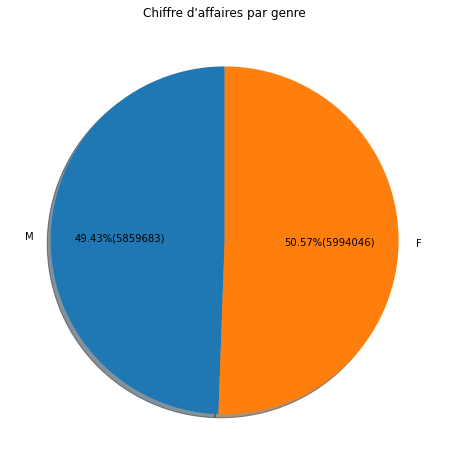

In [40]:
sex_ca = df.groupby('sex')[['price']].sum().round()
plt.figure(figsize=(8, 8))
plt.title("Chiffre d\'affaires par genre")
plt.pie(sex_ca['price'],labels=['M','F'],autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*sex_ca.price.sum()),shadow=True,startangle = 90)
plt.savefig('Chiffre d\'affaires par genre.png',transparent=True,dpi=300)
plt.show()

## <center> Le CA par catégorie

In [41]:
df.groupby('categ')[['price']].sum().round()

,price
categ,
0,4419731.0
1,4653723.0
2,2780275.0


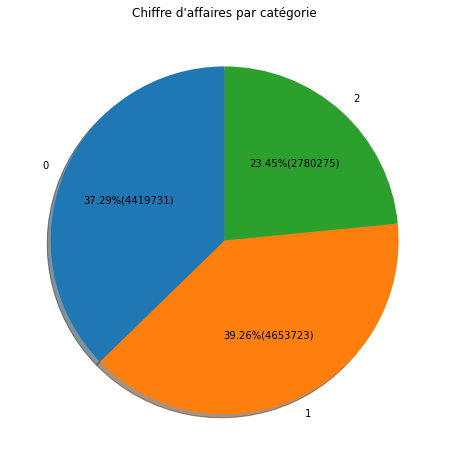

In [42]:
categ_ca = df.groupby('categ')[['price']].sum().round()
plt.figure(figsize=(8, 8))
plt.title("Chiffre d\'affaires par catégorie")
plt.pie(categ_ca['price'],labels=['0','1','2'],autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*categ_ca.price.sum()),shadow=True,startangle = 90)
plt.savefig('Chiffre d\'affaires par catégorie.png',transparent=True,dpi=300)
plt.show()

#### Références (zoom sur les tops / flops)

## <center>Les 10 références les + vendues *(en terme de chiffre d'affaires)*

In [43]:
top_ca=df.groupby('id_prod').price.sum().nlargest(10).to_frame()
top_ca

,price
id_prod,
2_159,94893.50
2_135,69334.95
2_112,65407.76
2_102,60736.78
2_209,56971.86
1_395,54356.25
1_369,54025.48
2_110,53846.25
2_39,53060.85


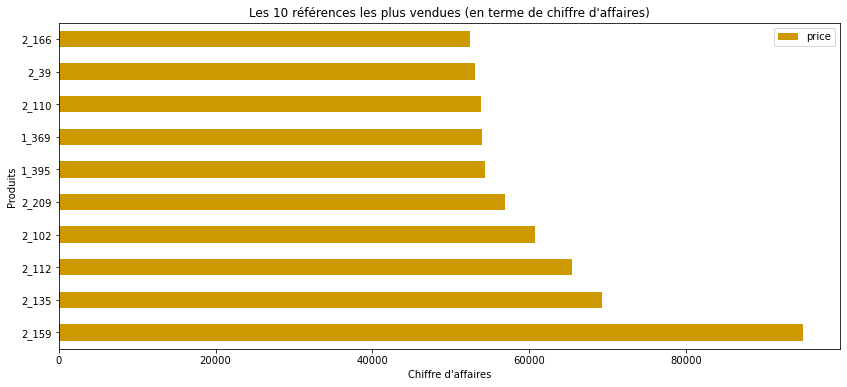

In [44]:
top_ca.plot(kind='barh', figsize=(14,6),color='#CC9900')
plt.title("Les 10 références les plus vendues (en terme de chiffre d'affaires)")
plt.ylabel('Produits')
plt.xlabel('Chiffre d\'affaires')
plt.savefig('Ref top CA.png',transparent=True,dpi=300)
plt.show();

## <center>Les 10 références les plus vendues *(en terme de nombre de ventes)*

In [45]:
top_vt=df['id_prod'].value_counts().nlargest(10).to_frame()
top_vt

,id_prod
1_369,2252
1_417,2189
1_414,2180
1_498,2128
1_425,2096
1_403,1960
1_412,1951
1_413,1945
1_406,1939
1_407,1935


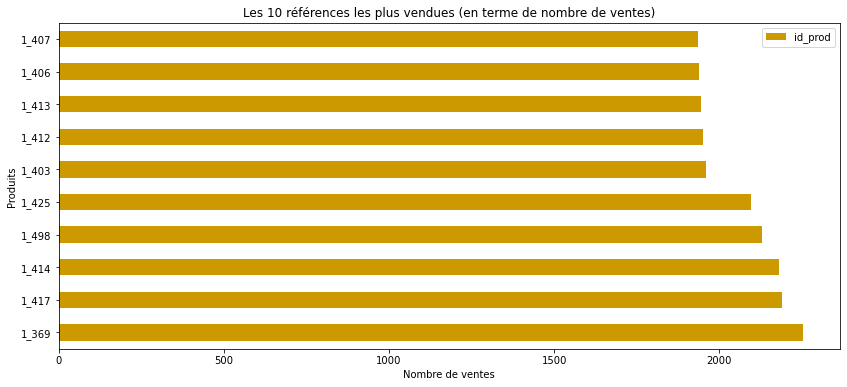

In [46]:
top_vt.plot(kind='barh', figsize=(14,6),color='#CC9900')
plt.title("Les 10 références les plus vendues (en terme de nombre de ventes)")
plt.ylabel('Produits')
plt.xlabel('Nombre de ventes')
plt.savefig('Ref top ventes.png',transparent=True,dpi=300)
plt.show()

## <center>Les 10 références les moins vendues *(en terme de chiffre d'affaires)*

In [47]:
flop_ca=df.groupby('id_prod')['price'].sum().to_frame().sort_values(by='price',ascending=True).iloc[0:10]
flop_ca

,price
id_prod,
0_1539,0.99
0_1284,1.38
0_1653,1.98
0_1601,1.99
0_807,1.99
0_541,1.99
0_1728,2.27
0_1498,2.48
0_898,2.54


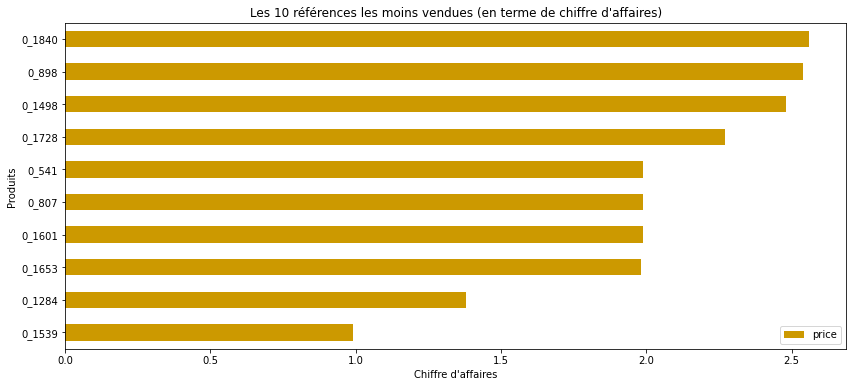

In [48]:
flop_ca.plot(kind='barh', figsize=(14,6),color='#CC9900')
plt.title("Les 10 références les moins vendues (en terme de chiffre d'affaires)")
plt.ylabel('Produits')
plt.xlabel('Chiffre d\'affaires')
plt.savefig('Ref flop CA.png',transparent=True,dpi=300);

## <center>Les 10 références les moins vendues *(en terme de nombre de ventes)*

In [49]:
flop_vt=df['id_prod'].value_counts().nsmallest(10).to_frame()
flop_vt

,id_prod
0_1601,1
0_541,1
0_1539,1
0_1728,1
0_1379,1
0_1151,1
0_833,1
0_1498,1
2_23,1
0_549,1


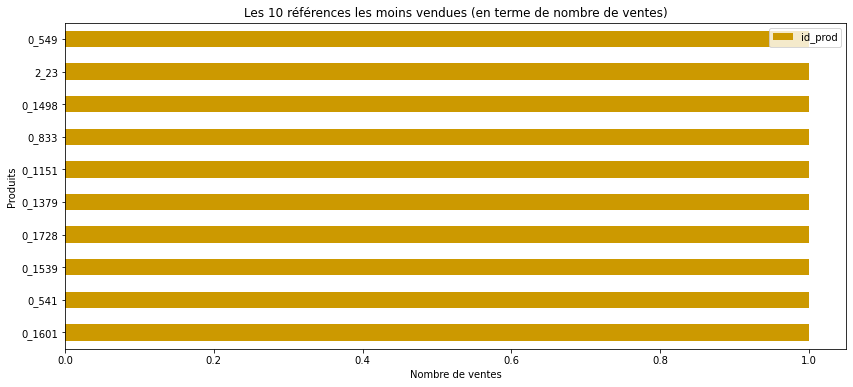

In [50]:
flop_vt.plot(kind='barh', figsize=(14,6),color='#CC9900')
plt.title("Les 10 références les moins vendues (en terme de nombre de ventes)")
plt.ylabel('Produits')
plt.xlabel('Nombre de ventes')
plt.savefig('Ref flop ventes.png',transparent=True,dpi=300)

#### Les catégories

## <center>Le nombre de produit par catégorie

In [51]:
print('Nous avons',df['id_prod'].nunique(),'références uniques sur notre site')

Nous avons 3265 références uniques sur notre site


In [52]:
df.groupby("categ")[['id_prod']].nunique()

,id_prod
categ,
0,2292
1,737
2,236


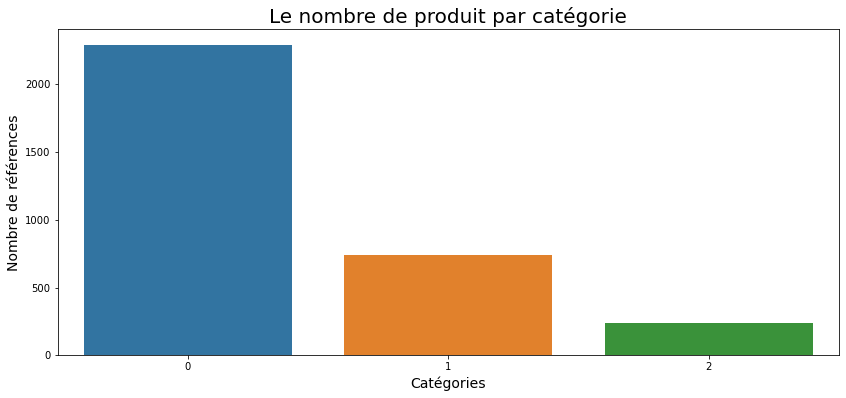

In [53]:
categ_prod = df.groupby("categ")[['id_prod']].nunique()
plt.figure(figsize=(14,6))
sb.barplot(x=categ_prod.index, y=categ_prod.id_prod)

plt.title('Le nombre de produit par catégorie', fontsize=20)
plt.xlabel('Catégories', fontsize=14)
plt.ylabel('Nombre de références', fontsize=14)
plt.savefig('Le nombre de produit par catégorie.png',transparent=True,dpi=300)
plt.show()

## <center> Le Prix des références par categorie

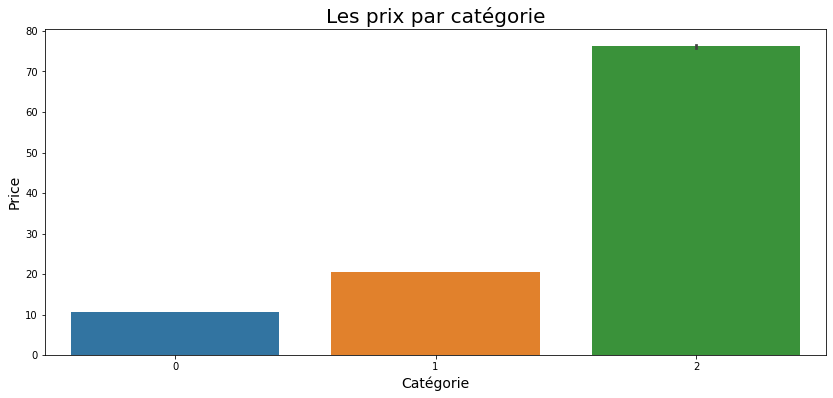

In [54]:
plt.figure(figsize=(14,6))
sb.barplot(data=df,x="categ",y="price")
plt.title('Les prix par catégorie', fontsize=20)
plt.xlabel('Catégorie', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.savefig('Le Prix des références par categorie.png',transparent=True,dpi=300)
plt.show()

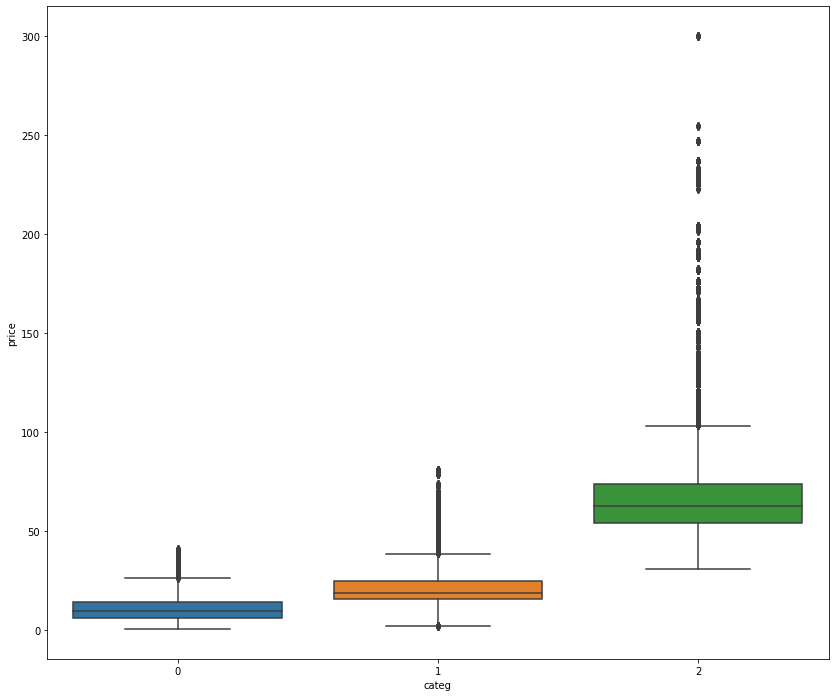

In [55]:
plt.figure(figsize=(14,12))
sb.boxplot(data=df,x="categ",y="price")
plt.show()

In [56]:
#prix moyen par catégorie
moy=df.groupby('categ')[['price']].mean()
moy

,price
categ,
0,10.638188
1,20.485730
2,76.207412


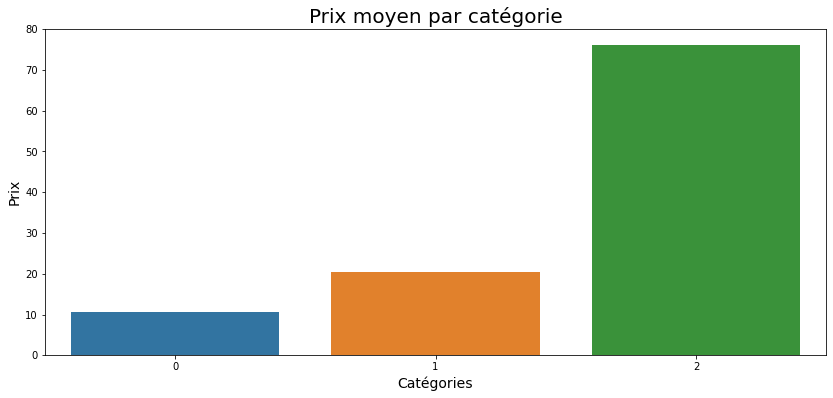

In [57]:
plt.figure(figsize=(14,6))
sb.barplot(data=moy,x=moy.index,y="price")
plt.title('Prix moyen par catégorie', fontsize=20)
plt.xlabel('Catégories', fontsize=14)
plt.ylabel('Prix', fontsize=14)
plt.savefig('Le Prix moyen par categorie.png',transparent=True,dpi=300)
plt.show()

# Analyse du Chiffre d'affaires dans le temps

Le rééchantillonnage est un moyen de regrouper les données par unités de temps.</p>
j'ai efectué un rééchantillonnage par jour («D»)

In [58]:
# Definir la colonne date comme index
day = df.set_index('date', inplace=True)

In [59]:
#Rééchantillonnage par jour 
day = df["price"].resample("D").sum()

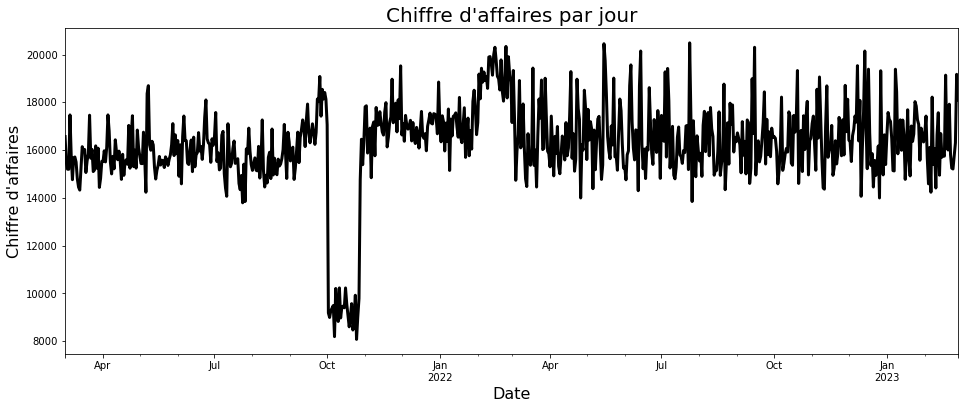

In [60]:
#Choix du graphique "line plot"
day.plot(linewidth=3, figsize=(16,6),color="#000000")

# Modification du titre et axes 
plt.title('Chiffre d\'affaires par jour', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Chiffre d\'affaires', fontsize=16)
plt.savefig('Chiffre d\'affaires par jour.png',transparent=True,dpi=300)
plt.show()

Une moyenne mobile "MM" permet de lisser une série de valeurs exprimées en fonction du temps (série chronologique). Elle permet d'éliminer les fluctuations les moins significatives</p>
Lisser à l’aide d’un ordre impair pour éviter des phénomènes de déphasage de la série lissée.</p>
Le but de cette operation est de souligner les tendances à long terme</p>
"mobile" parce qu'elle est recalculée de façon continue</p>
[wikipedia](https://fr.wikipedia.org/wiki/Moyenne_mobile)</p>
[Insee](https://www.insee.fr/fr/metadonnees/definition/c2091)

In [61]:
#Convertir une serie en dataFrame
day = day.to_frame()

In [62]:
# création d'une colone Moyenne Mobile Simple "MMS" basé sur le prix ( toutes les 15 obervations=> 15 jours )
day['MMS_15'] = day.price.rolling(15, min_periods=1).mean()

In [63]:
day.head()

,price,MMS_15
date,,
2021-03-01,16565.22,16565.2200
2021-03-02,15486.45,16025.8350
2021-03-03,15198.69,15750.1200
2021-03-04,15196.07,15611.6075
2021-03-05,17471.37,15983.5600


In [64]:
day.describe()

,price,MMS_15
count,730.000000,730.000000
mean,16237.984493,16229.705436
std,1847.906447,1373.935681
min,8076.040000,9182.060667
25%,15476.225000,15953.853000
50%,16223.305000,16396.056667
75%,17185.785000,16764.173667
max,20487.680000,19390.390667


Le chiffre d'affaires varie entre 8076 € au min et 20487€ au max

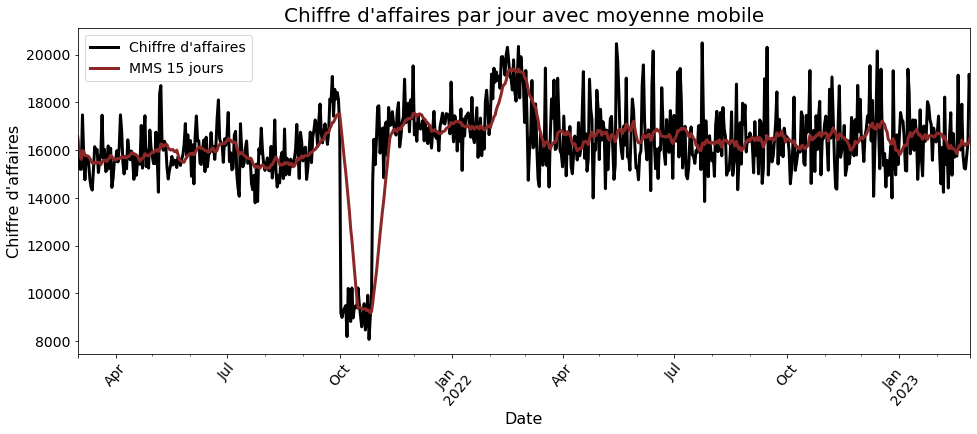

In [65]:
# selection des couleurs pour le graphique
colors = ['#000000','#8C2727']

# line plot - choix des couleurs / taille des lignes / taille du graphique
day.plot(color=colors, linewidth=3, figsize=(16,6))

# modification de la taille des polices pour les etiquettes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Chiffre d\'affaires', 'MMS 15 jours'], fontsize=14)

# title and labels
plt.title('Chiffre d\'affaires par jour avec moyenne mobile', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Chiffre d\'affaires', fontsize=16)
plt.xticks(rotation=50)
plt.savefig('Chiffre d\'affaires par jour et moyenne mobile.png',transparent=True,dpi=300)
plt.show()

Baisse du Chiffre d'affaires sur octobre

In [66]:
dix=df[(df["année"]=="2021") & (df["mois"]== "10") & (df["categ"]== 1)]
dix.groupby(["année","mois","jours"])["categ"].value_counts().head()

année  mois  jours  categ
2021   10    01     1        344
             28     1        316
             29     1        326
             30     1        338
             31     1        342
Name: categ, dtype: int64

Il y a un problème au niveau de la référence 1 , il n'y a pas de ventes entre le 2 et le 27 octobre.

### Le profils de nos clients

Age

il y a 75 ans qui sépare le plus jeune client (né en 2004) du plus ancien (né en 1929)
</p>j'ai fait 5 groupes de 15 ans (j'ai pris 15 ans car c'est l'age de la majorité numérique)  :</p>
+75 ans / 60-75 / 45-60 / 30-45 / 15-30</p>

In [67]:
#ne garder que les clients uniques

df_bin = pd.pivot_table(df,index=["client_id"])
df_bin

,age,birth,categ,price
client_id,,,,
c_1,66,1955,0.256410,14.312308
c_10,65,1956,0.724138,23.337931
c_100,29,1992,0.875000,31.856250
c_1000,55,1966,0.656000,18.095120
c_1001,39,1982,0.323529,17.773137
...,...,...,...,...
c_995,66,1955,0.214286,13.529286
c_996,51,1970,0.578947,17.111368
c_997,27,1994,0.864407,25.254407


In [68]:
# grouper des données par classe
def binning(col, cut_points, labels=None):
    # Définir les valeurs min et max:
    minval = col.min()
    maxval = col.max()
    # Créer une liste en ajoutant min et max à cut_points
    break_points = [minval] + cut_points + [maxval]
    # Si aucun label, on utilise par défaut les labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)
    # Regroupement en utilisant la fonction cut de Pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin
cut_points = [1944,1959,1974,1989]
labels = ["+75 ans","60-75","45-60","30-45","15-30"]
df_bin["birth_bin"] = binning(df_bin["birth"], cut_points, labels)
print(pd.value_counts(df_bin["birth_bin"], sort=False))

+75 ans     261
60-75      1111
45-60      2047
30-45      2621
15-30      2560
Name: birth_bin, dtype: int64


In [69]:
#le nombre de clients dans chaque tranche d'age
count=df_bin.groupby(df_bin["birth_bin"]).count()[['age']]
count

,age
birth_bin,
+75 ans,261
60-75,1111
45-60,2047
30-45,2621
15-30,2560


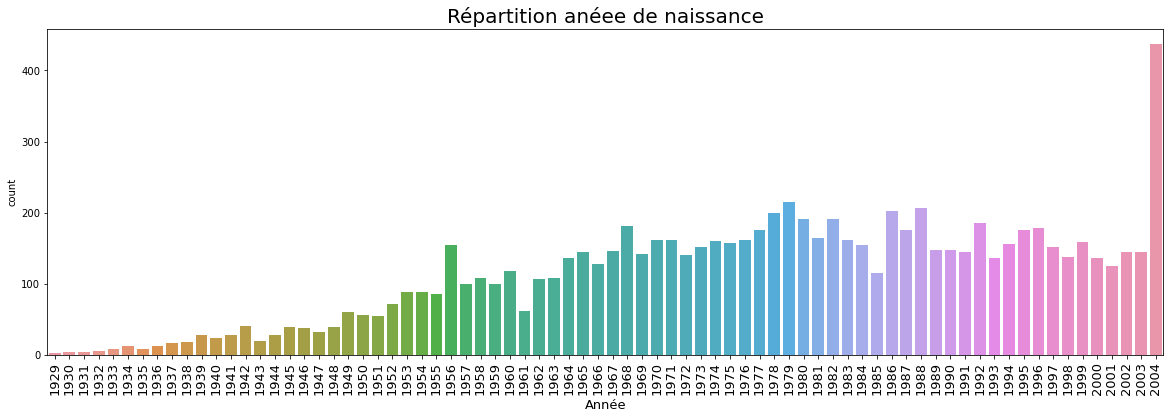

In [70]:
plt.figure(figsize=(20,6))
sb.countplot(x='birth', data=df_bin)
plt.title('Répartition anéee de naissance', fontsize=20)
plt.xlabel('Année', fontsize=13)
plt.xticks(size=13)
plt.xticks(rotation=90)
plt.savefig('Répartition annee.png',transparent=True,dpi=300)
plt.show();

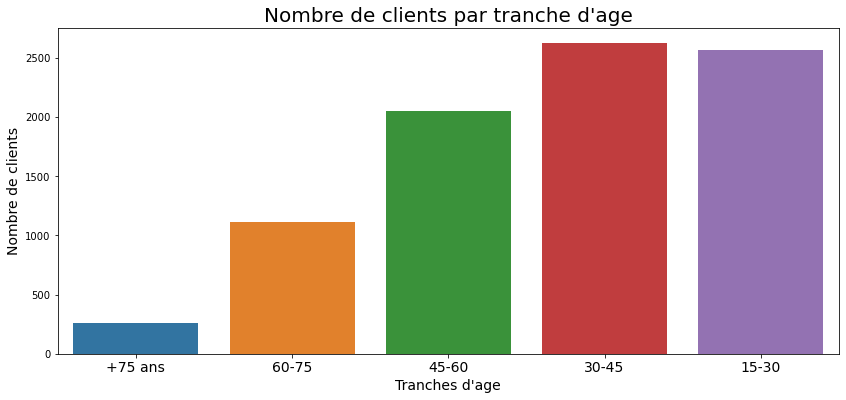

In [71]:
plt.figure(figsize=(14,6))
sb.barplot(x=count.index, y=count.age)
plt.title('Nombre de clients par tranche d\'age', fontsize=20)
plt.xlabel('Tranches d\'age', fontsize=14)
plt.ylabel('Nombre de clients', fontsize=14)
plt.xticks(size=14)

plt.savefig('Nombre de clients par tranche d\'age.png',transparent=True,dpi=300)
plt.show();

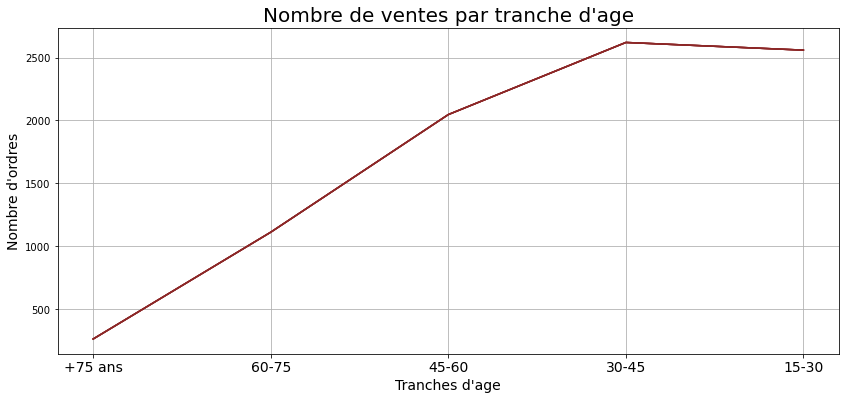

In [72]:
b_bin2 = [birth_bin for birth_bin , df_bin in df_bin.groupby(df_bin["birth_bin"])]

plt.figure(figsize=(14,6))
plt.plot(b_bin2,df_bin.groupby(df_bin["birth_bin"]).count(), color="#8C2727")

plt.xticks(b_bin2)
plt.title('Nombre de ventes par tranche d\'age', fontsize=20)
plt.xlabel('Tranches d\'age', fontsize=14)
plt.ylabel('Nombre d\'ordres', fontsize=14)
plt.xticks(size=14)
plt.grid()
plt.savefig('Nombre de ventes par tranche d\'age.png',transparent=True,dpi=300)
plt.show()

In [73]:
df.groupby("birth").count()

,id_prod,session_id,client_id,année,mois,année_mois,jours,heure,price,categ,sex,age
birth,,,,,,,,,,,,
1929,201,201,201,201,201,201,201,201,201,201,201,201
1930,226,226,226,226,226,226,226,226,226,226,226,226
1931,170,170,170,170,170,170,170,170,170,170,170,170
1932,311,311,311,311,311,311,311,311,311,311,311,311
1933,326,326,326,326,326,326,326,326,326,326,326,326
...,...,...,...,...,...,...,...,...,...,...,...,...
2000,4413,4413,4413,4413,4413,4413,4413,4413,4413,4413,4413,4413
2001,4252,4252,4252,4252,4252,4252,4252,4252,4252,4252,4252,4252
2002,4584,4584,4584,4584,4584,4584,4584,4584,4584,4584,4584,4584


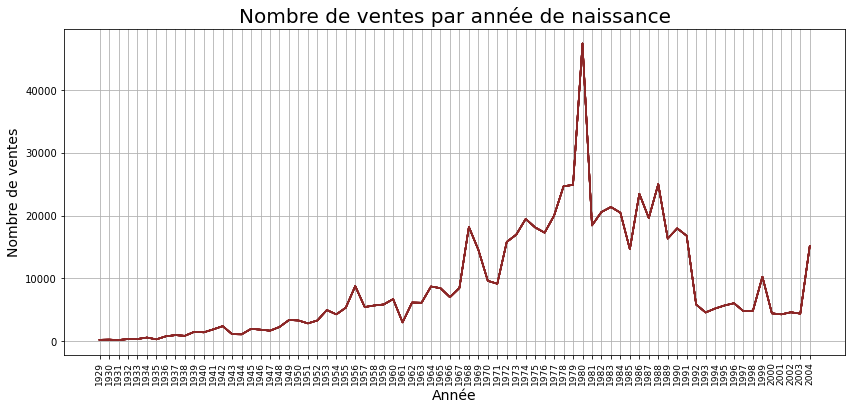

In [74]:
age = [birth for birth , df in df.groupby(df["birth"])]

plt.figure(figsize=(14,6))
plt.plot(age,df.groupby(df["birth"]).count(), color="#8C2727")
plt.xticks(age)
plt.title('Nombre de ventes par année de naissance', fontsize=20)
plt.xlabel('Année', fontsize=14)
plt.ylabel('Nombre de ventes', fontsize=14)
plt.xticks(rotation=90,size=9)
plt.grid()
plt.savefig('Nombre de ventes par année de naissances.png',transparent=True,dpi=300)
plt.show()

In [75]:
#Les 5 années qui ont le plus gros chiffre d'affaires
df.groupby('birth')[['price']].sum().nlargest(5,'price')

,price
birth,
1980,613614.58
2004,609013.69
1999,489497.54
1979,334267.72
1988,330760.73


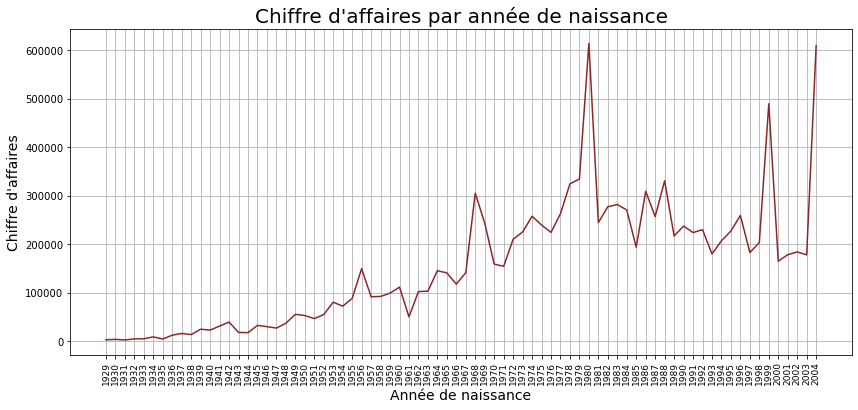

In [76]:
ca_age = [birth for birth , df in df.groupby(df["birth"])]

plt.figure(figsize=(14,6))
plt.plot(ca_age,df.groupby('birth')[['price']].sum(), color="#8C2727")
plt.xticks(ca_age)
plt.title('Chiffre d\'affaires par année de naissance', fontsize=20)
plt.xlabel('Année de naissance', fontsize=14)
plt.ylabel('Chiffre d\'affaires', fontsize=14)
plt.xticks(rotation=90,size=9)
plt.grid()
plt.savefig('Chiffre d\'affaire par année de naissance.png',transparent=True,dpi=300)
plt.show()

In [77]:
# clients : profils + répartition du chiffre d'affaires entre eux
df.groupby('age')[['price']].sum().nlargest(5,'price').round()

,price
age,
41,613615.0
17,609014.0
22,489498.0
42,334268.0
33,330761.0


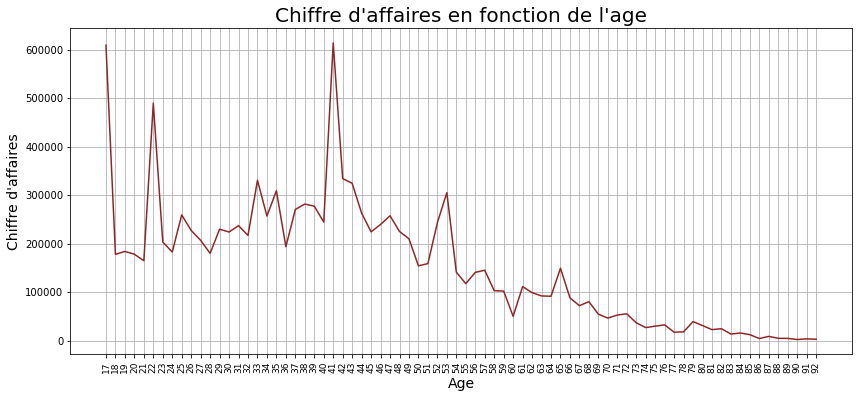

In [78]:
ca_age1 = [age for age , df in df.groupby(df["age"])]

plt.figure(figsize=(14,6))
plt.plot(ca_age1,df.groupby('age')[['price']].sum(), color="#8C2727")
plt.xticks(ca_age1)
plt.title('Chiffre d\'affaires en fonction de l\'age', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Chiffre d\'affaires', fontsize=14)
plt.xticks(rotation=90,size=9)
plt.grid()
plt.savefig('Chiffre d\'affaires en fonction de l\'age.png',transparent=True,dpi=300)
plt.show()

Habitudes d'achat

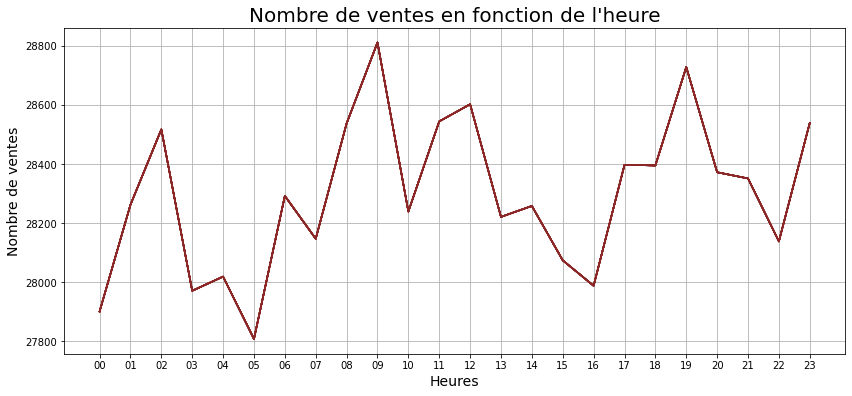

In [79]:
heures = [heure for heure , df in df.groupby(df["heure"])]

plt.figure(figsize=(14,6))
plt.plot(heures,df.groupby(df["heure"]).count(), color="#8C2727")
plt.xticks(heures)
plt.title('Nombre de ventes en fonction de l\'heure', fontsize=20)
plt.xlabel('Heures', fontsize=14)
plt.ylabel('Nombre de ventes', fontsize=14)
plt.grid()
plt.savefig('Nombre de ventes par heure.png',transparent=True,dpi=300)
plt.show()

La plupart des ventes sont faites a 9h 12h et 19h 

## Répartition du chiffre d'affaires entre les clients

La courbe de Lorenz (Lorenz curve ou Cumulative Accuracy Profile (CAP) Curve ) est une représentation graphique permettant de visualiser la distribution d'une variable (actif, patrimoine, revenu, etc.) au sein d'une population.<p>
Elle permet de représenter la fonction de répartition qui associe à chaque fractile[1] de population la part de richesse détenue par celui-ci. Autrement dit, elle représente combien la part X d'une population détient de part Y d'une variable.

[Courbe de Lorenz ](http://www.bsi-economics.org/287-%E2%98%86-la-courbe-de-lorenz)</p>
[Courbe de Lorenz OpenClassrooms](https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4730366-familiarisez-vous-avec-les-mesures-de-concentration#/id/r-4741157)

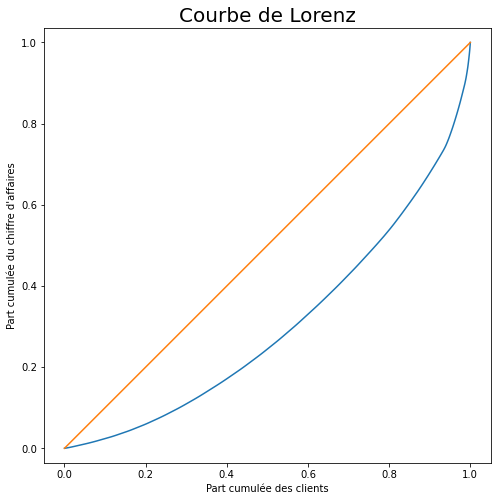

In [80]:
CL = df['price'].values
n = len(CL)
lorenz = np.cumsum(np.sort(CL)) / CL.sum() # calculer la somme cumulée et trier les individus dans l'ordre croissant des valeurs de la variable et normaliser
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.figure(figsize=(8,8))

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) #créer l'axe de 0 a 1 Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.


plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.plot([0,1], [0,1])
plt.title('Courbe de Lorenz', fontsize=20)
plt.xlabel('Part cumulée des clients')
plt.ylabel('Part cumulée du chiffre d\'affaires')

plt.savefig('Répartition du chiffre d\'affaires entre les clients.png',transparent=True,dpi=300)
plt.show()

En orange => La droite représente la situation dans laquelle la distribution du chiffre d'affaires serait parfaitement égalitaire.

 **Calcul de [l'indice de Gini](https://www.vie-publique.fr/fiches/270161-lindice-de-gini)**

Le coefficient de Gini, ou indice de Gini, est une mesure statistique permettant de rendre compte de la répartition d'une variable  au sein d'une population. Autrement dit, il mesure le niveau d'inégalité de la répartition d'une variable dans la population.<P>
L’indice (ou coefficient) de Gini est un indicateur synthétique d’inégalités.<P>
Il varie entre 0 et 1.<P>
Il est égal à 0 dans une situation d’égalité parfaite.<P>
Il est égal à 1 dans une situation la plus inégalitaire possible.<P>
Entre 0 et 1, l’inégalité est d’autant plus forte que l’indice de Gini est élevé.

In [81]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
gini

0.3954702179569495

La répartition du chiffre d'affaires est plutôt égalitaire

# Analyse ciblée sur les clients

## Corrélations linéaires entre les variables quantitatives

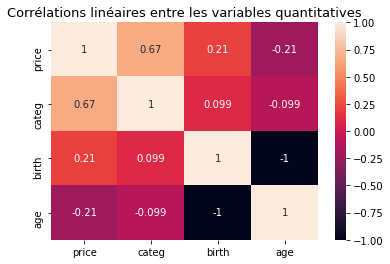

In [82]:
#Carte des corrélations (Pearson)
sb.heatmap(df.corr(), annot=True)
plt.title('Corrélations linéaires entre les variables quantitatives', fontsize=13)

plt.savefig('Corrélations linéaires entre les variables quantitatives.png',dpi=300)
plt.show()

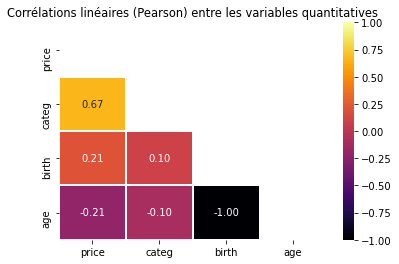

In [83]:
#Carte des corrélations (Pearson) améliorée

mask=np.triu(np.ones_like(df.corr(),dtype=bool))

sb.heatmap(df.corr(),mask=mask,center=0,cmap='inferno',linewidths=1, annot=True,fmt=".2f",vmin=-1,vmax=1)
plt.title('Corrélations linéaires (Pearson) entre les variables quantitatives', fontsize=11.5)

plt.savefig('Corrélations linéaires entre les variables quantitatives ameliorée.png',dpi=300)
plt.show()

Affiche les coefficents de corrélations entre les variables quantitatives (tend vers 1 pour les corrélations positive et vers -1 pour les corrélations négative

- il existe une corrélation positive modérément forte  entre la categorie et le prix
- il existe une corrélation négative forte  entre l'age et la date de naissance (plus la date de naissance augmente plus l'âge diminue)

# Test statistique

En statistiques, un test, ou test d'hypothèse, est une procédure de décision entre deux hypothèses.</p>
Il s'agit d'une démarche consistant à rejeter ou à ne pas rejeter une hypothèse statistique, appelée hypothèse nulle, en fonction d'un échantillon de données.</p>
L'hypothèse nulle notée H0 est celle que l'on considère vraie a priori,c'est le scénario par défaut que l’on veut tester (il n'y a pas de lien\ les variables sont independantes\ la distribution est normale ...).</p>
L’hypothèse alternative ou H1 est par définition son opposé.</p>
Tous les tests statistiques fournissent une p-valeur ou pvalue : la probabilité de se tromper si l’on rejette H0.</p>
C’est la comparaison de cette pvalue avec le risque d’erreur initialement choisi( alpha à 5%) qui va permettre de de rejetter ou non l’hypothèse de départ.</p>

In [84]:
#Importation de la librairie scipy.stats

import scipy.stats as st
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr

# Test de normalité 
from scipy.stats import shapiro # Shapiro-Wilk Test
from scipy.stats import normaltest # D’Agostino’s K^2 Test
from scipy.stats import ks_2samp #  Kolmogorov-Smirnov 
from scipy.stats import anderson # Anderson-Darling Test

from scipy.stats import f

In [85]:
#Importation de la librairie statsmodels

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols # régression ordinaire des moindres carrés (OLS)
from statsmodels.stats.anova import anova_lm

### Lien entre l’âge des clients et les catégories des livres achetés

Analysez une variable quantitative et une qualitative par ANOVA (Analysis of variance)

Le test compare la différence entre les points individuels de notre ensemble de données et la ligne ajustée prédite pour mesurer la quantité d'erreur produite.</p>
Elle se fonde sur une décomposition de la variance en une partie « explicable » (variance inter-groupes) et une partie « erreur » (variance globale intragroupe — ou variance résiduelle), supposée distribuée selon une loi normale.</p>
La régression linéaire calcule une équation qui minimise la distance entre la ligne ajustée et tous les points de données. Techniquement, la régression ordinaire des [moindres carrés](https://desktop.arcgis.com/fr/arcmap/10.3/tools/spatial-statistics-toolbox/what-they-don-t-tell-you-about-regression-analysis.htm) (OLS : Ordinary Least Squares) minimise la somme des résidus au carré.

In [86]:
#selection de nos variables
AC = df[{"age","categ"}]
AC = AC.reset_index()
AC = AC.drop(['date'], axis=1)

In [87]:
#convertir une variable quantitative en variable qualitative (int64=>objet)
AC['categ'] = AC['categ'].apply(str)

In [88]:
AC

,age,categ
0,35,0
1,35,0
2,35,0
3,35,0
4,35,0
...,...,...
679106,20,2
679107,61,0
679108,61,0
679109,29,2


Définition des hypothèses:   
  - H0: Les deux variables (age et categories) sont indépendantes.
  - H1: Il existe une dépendance entre les deux variables (age et categories).

Définition des hypothèses:  
  - H0 : Il n’y a pas de lien entre les deux variables
  - H1 : Il y a un lien entre les deux variables

In [89]:
model = smf.ols("age ~ categ",data=AC).fit()# ols=création de notre model et .fit=>la regression linéaire des valeurs residuelles
aov_table= anova_lm(model,tup=2)

In [90]:
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
categ,2.0,1.489751e+07,7.448754e+06,45879.681847,0.0
Residual,679108.0,1.102560e+08,1.623541e+02,NaN,NaN


In [91]:
print(aov_table)

                df        sum_sq       mean_sq             F  PR(>F)
categ          2.0  1.489751e+07  7.448754e+06  45879.681847     0.0
Residual  679108.0  1.102560e+08  1.623541e+02           NaN     NaN


df = degré de libertée
PR(>F) p value = difference significative (HSD : honestly significant difference)

df= degrés de liberté</p>
F = statistic value for significance of adding model terms</p>
PR(>F) = P-value for significance of adding model terms.</p>

In [92]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                 4.588e+04
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        13:55:58   Log-Likelihood:            -2.6919e+06
No. Observations:              679111   AIC:                         5.384e+06
Df Residuals:                  679108   BIC:                         5.384e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.8974      0.020   2170.021      0.000      42.859      42.936
categ[T.1]     3.7538      0.033    112.901      0.000       3.689       3.819
categ[T.2]   -17.9494      0.070   -257.980      0.000     -18.086     -17.813
==============================================================================
Omnibus:                    46503.151   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63702.969
Skew:                           0.604   Prob(JB):                         0.00
Kurtosis:                       3.891   Cond. No.                         4.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**R-squared**( coefficient de détermination) : 11.9% la mesure de la part de la variable indépendante expliquée par les changements dans nos variables dépendantes.Compris entre 0 et 1 (0.119 est assez faible)</p>
**P>|t|**: la p value est de 0.00 pour categ c'est dire qu'il y a 0% de chance que la variable catégorielle n'ait pas d'effet sur la variable dépendante, l'âge, et que nos résultats soient produits par le hasard.</p>
**Prob(Omnibus)** : test statistique mesurant la probabilité que les résidus soient normalement distribués. Un 1 indiquerait une distribution parfaitement normale.

Le R-carré est une mesure statistique de la proximité des données à la droite de régression ajustée.</p>
Le R-carré est toujours compris entre 0 et 100%:</p>
   - 0 % indique que le modèle n’explique aucune de la variabilité des données de réponse autour de sa moyenne.
   - 100% indique que le modèle explique toute la variabilité des données de réponse autour de sa moyenne.

</p>En général, plus le R-carré est élevé, meilleur est le modèle qui s’ajuste à vos données.

#### Il n'y a pas de lien entre le R2 et la p-value

Il n’y a **pas de lien entre le coefficient de détermination et la p-value** (du test de la pente) car ces deux paramètres **mesurent des choses différentes**. Le **R2 indique la part de variabilité expliquée par le modèle**. De son côté, la **p-value nous permet de conclure sur la significativité de la relation linéaire** entre la variable réponse et la variable prédictive.

La **part de variabilité expliquée par un modèle peut dépendre du contexte**, elle peut être de l’ordre de **80% dans certains domaines, et uniquement de 10%** dans d’autres, comme en biologie par exemple. **La part de variabilité expliquée par le modèle, ne préjuge pas de la significativité de la relation** entre la réponse et la variable prédictive. Dis autrement, **même si un modèle n’explique que peu de variabilité, la p-value du test de la pente demeure valide**, à condition que les hypothèses du test soient validées, bien entendu.

Avant d’examiner les mesures statistiques pour l’adéquation de l’ajustement, nous devpons vérifier le graphique des valeurs résiduelles. Le graphique des valeurs résiduelles peut révéler des schémas/tendances indésirables qui indiquent des résultats biaisés.

In [93]:
from statsmodels.graphics.gofplots import qqplot

In [94]:
# obtenir les valeurs résiduelles de notre variable "model"
MR = model.resid 

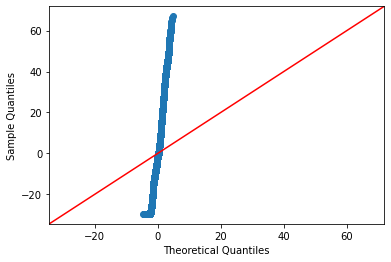

<Figure size 576x576 with 0 Axes>

In [95]:
# graphique des valeurs résiduelles
MR = model.resid
fig = qqplot(MR,line='45')
plt.figure(figsize=(8,8))

plt.show()

Le "diagramme Quantile-Quantile" ou "diagramme Q-Q" ou "Q-Q plot" est un outil graphique permettant d'évaluer la pertinence de l'ajustement d'une distribution donnée à un modèle théorique. à partir de la série statistique observée, on calcule alors un certain nombre de quantiles. Si la série statistique suit bien la distribution théorique choisie, on devrait avoir les quantiles observés égaux aux quantiles associés au modèle théorique.</p>
Plus les données (points) se rapprochent de la droite, plus la distribution empirique est dite normale. Les données de l'exemple 1 sont proches de la droite tandis que les données de l'exemple 2 sont plus éloignées.

Comme nous le voyons sur ce  graphique **les valeurs residuelles n'ont pas une distribution normale** ,nous devons donc utiliser une autre test plus adapté

Le test de **kruskal-wallis** est l'equivalent non parametric de l'ANOVA</p>
Le test de [Kruskal-Wallis](https://support.minitab.com/fr-fr/minitab/20/help-and-how-to/statistics/nonparametrics/how-to/kruskal-wallis-test/interpret-the-results/key-results/) est un test robuste non paramétrique. Pas besoin de conditions préalables pour l'appliquer. Il permet de savoir, pour une variable pour laquelle on dispose de plusieurs catégories, si au moins une catégorie diffère.</p>
Comme il s'applique à la médiane, il peut passer en force même si les valeurs ne se répartissent pas selon la loi normale.</p>
The [Kruskal-Wallis H-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html) tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post hoc comparisons between groups are required to determine which groups are different.*

In [96]:
# Appliquer un Kruskal pour n catégories en partant d'une variable numérique et d'une variable catégorielle (approche classique)

x = AC['age']
y = AC['categ']

kstat, pval = st.kruskal(*[AC["age"].values for name, group in AC.groupby("categ")])

print("La p-value est de : ",round(pval,5))# Si pval petit (au moins inférieure à 0.05, alors on peut parler de différence significative
print("Le résultat du test est de : ",round(kstat,5))

La p-value est de :  1.0
Le résultat du test est de :  -0.0


la p-value est 1 ce qui signifie qu'il n'y a aucune chance que l'age influe sur la catégorie, on ne rejette pas H0

Définition des hypothèses:  
  - H0 : Il n’y a pas de lien entre les deux variables
  - H1 : Il y a un lien entre les deux variables

In [97]:
# test de kruskal-wallis

x = AC['age']
y = AC['categ']

kstat, pval = st.kruskal(*[AC["age"].values for name, group in AC.groupby("categ")])

print('kstat=%.3f, p-value=%.3f' % (kstat, pval))
if pval > 0.05:
    print('H0 : Il n’y a pas de lien entre les deux variables')
    print('Étant donné que la P-Value est supérieure au niveau de signification alpha=0.05, on ne peut pas rejeter H0')
    print('le risque de rejeter H0 alors qu\'elle est vraie est de',round(pval*100,3),'%')
else:
    print('H1 : Il y a probablement un lien entre les deux variables')
    print('Étant donné que la P-Value est inférieure au niveau de signification alpha=0.05, on doit rejeter H0 et retenir H1')
    print('le risque de rejeter H0 alors qu\'elle est vraie est de',round(pval*100,3),'%')

kstat=-0.000, p-value=1.000
H0 : Il n’y a pas de lien entre les deux variables
Étant donné que la P-Value est supérieure au niveau de signification alpha=0.05, on ne peut pas rejeter H0
le risque de rejeter H0 alors qu'elle est vraie est de 100.0 %


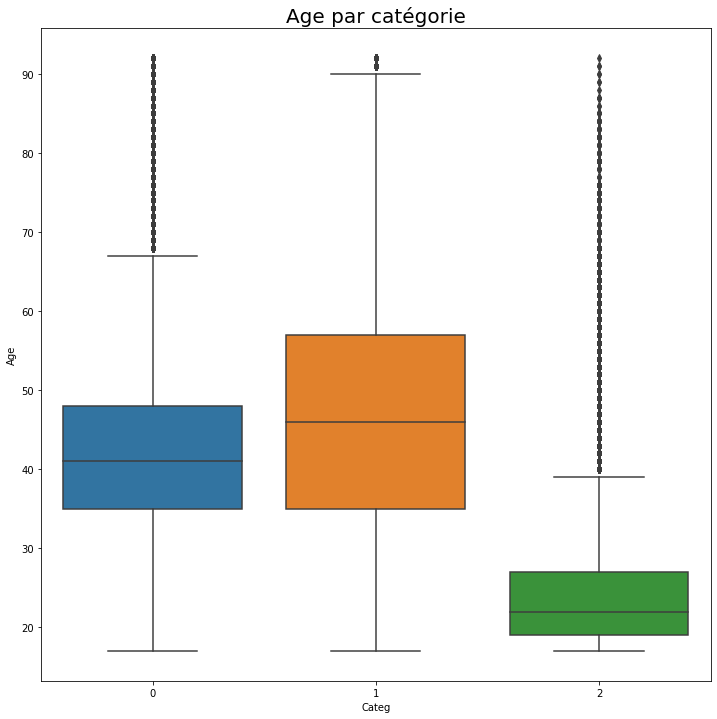

In [98]:
plt.figure(figsize=(12,12))
sb.boxplot(data=AC,x="categ",y="age")
plt.title('Age par catégorie', fontsize=20)
plt.xlabel('Categ',fontsize=10)
plt.ylabel('Age',fontsize=10)
plt.savefig('Lien entre l\'âge et categ.png',transparent=True,dpi=300)
plt.show();

### Lien entre l’âge des clients et le montant total des achats

In [99]:
#création d'un sous ensemble age-montant total des achats

ACA = df.groupby('age')[['price']].sum()
ACA = ACA.sort_index()
ACA.index.name = 'Age'
ACA = ACA.rename(columns={"price": "CA"})

ACA

,CA
Age,
17,609013.69
18,178195.78
19,184177.35
20,178497.70
21,165007.98
...,...
88,5254.35
89,5043.19
90,2815.45


Corrélation de **Pearson** si la distribution **est normale/Gaussienne/paramétrique**</p>
Corrélation de **Spearman** si la distribution **n'est pas normale/Gaussienne/paramétrique**

In [100]:
# D’Agostino’s K^2 Test

data = ACA.index
stat, p = normaltest(data)
print('stat=%.3f, p-value=%.3f' % (stat, p))
if p > 0.05:
    print('H0 : La distribution observée est compatible avec une distribution théorique normale')
else:
    print('H1 : La distribution observée n\'est pas compatible avec la loi normale')

stat=23.333, p-value=0.000
H1 : La distribution observée n'est pas compatible avec la loi normale


In [101]:
# D’Agostino’s K^2 Test

data = ACA['CA']
stat, p = normaltest(data)
print('stat=%.3f, p-value=%.3f' % (stat, p))
if p > 0.05:
    print('H0 : La distribution observée est compatible avec une distribution théorique normale')
else:
    print('H1 : La distribution observée n\'est pas compatible avec la loi normale')

stat=21.899, p-value=0.000
H1 : La distribution observée n'est pas compatible avec la loi normale


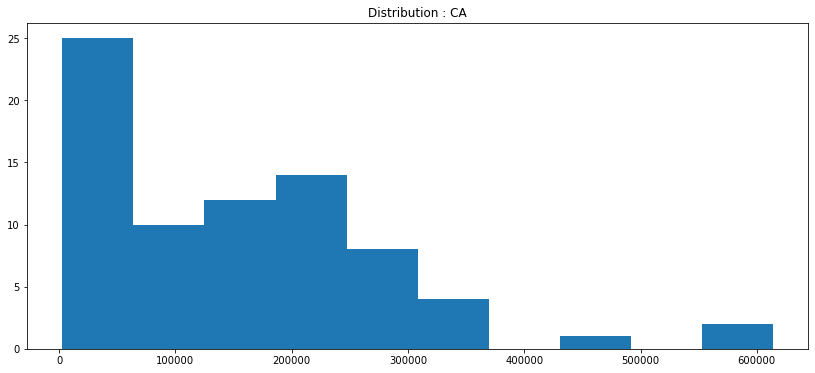

In [102]:
data = ACA['CA']
plt.figure(figsize=(14,6))
plt.hist(data)
plt.title("Distribution : CA")
plt.show()

Spearman’s Rank Correlation

Evalue la relation monotone entre deux variables continues ou ordinales. Dans une relation monotone, les variables ont tendance à changer ensemble, mais pas forcément à une vitesse constante.</p>

Hypothèses</p>
   - Les observations de chaque échantillon sont indépendantes et identiquement distribuées. (iid).
   - Les observations de chaque échantillon peuvent être classées.

Interprétation</p>
   - H0: les deux échantillons sont indépendants.
   - H1: il existe une dépendance entre les échantillons.


Définition des hypothèses:  
   - H0: les deux variables (age et montant total des achats) sont indépendantes.
   - H1: il existe une dépendance entre l'age et le montant total des achats.

Définition des hypothèses:  
  - H0 : Il n’y a pas de lien entre les deux variables
  - H1 : Il y a un lien entre les deux variables

In [103]:
#Test corrélation de Spearman

data1 = ACA.index
data2 = ACA['CA']
stat, p = spearmanr(data1, data2)
print('Coefficient de corrélation=%.3f, p-value=%.3f' % (stat, p))
if p > 0.05:
    print('H0 : Il n’y a pas de lien entre les deux variables')
else:
    print('H1 : Il y a probablement un lien entre les deux variables')

Coefficient de corrélation=-0.858, p-value=0.000
H1 : Il y a probablement un lien entre les deux variables


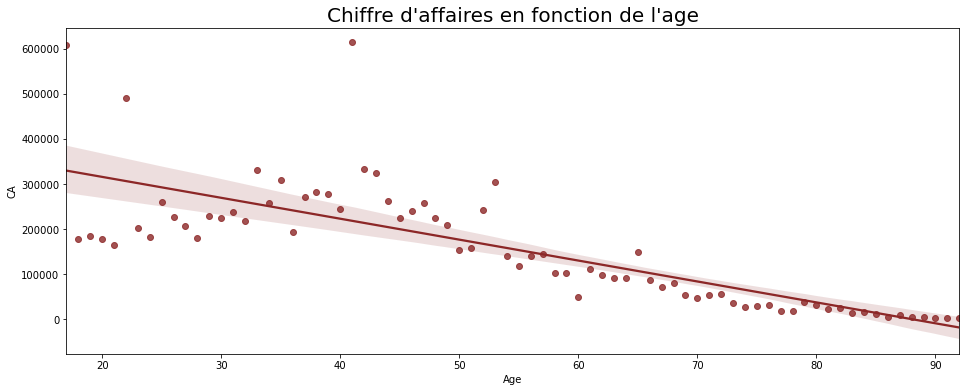

In [104]:
plt.figure(figsize=(16,6))
sb.regplot(x=ACA.index, y=ACA["CA"], color="#8C2727")
plt.title('Chiffre d\'affaires en fonction de l\'age', fontsize=20)
plt.savefig('Lien entre l\'âge des clients et et le montant total des achats.png',transparent=True,dpi=300)
plt.show()

Il existe une correlation positive jusqu'à 42 ans (plus l'age augmente plus le montant totale des achats augmente)</p>
Il existe une correlation negative a partir de 44 ans (plus l'age augmente plus le montant totale des achats diminue)

### Lien entre l’âge des clients et la fréquence d’achat
*[Fréquence d’achat](https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4728126-presentez-une-variable-sous-forme-de-tableau#/id/r-4728244) = Nombre total de commandes / Nombre de clients uniques*

In [105]:
freq = df.groupby('age')[['session_id']].nunique()/df['session_id'].nunique()# calcul de la fréquence
freq = freq.rename(columns={"session_id": "Fréquence"})# renomer la colonne session_id en fréquence
freq.index.name = 'Age'
freq

,Fréquence
Age,
17,0.025108
18,0.007500
19,0.007608
20,0.007102
21,0.007073
...,...
88,0.000681
89,0.000602
90,0.000280


In [106]:
# Vérification que la somme totale des fréquences est bien egale a 1
freq.sum()

Fréquence    1.0
dtype: float64

In [107]:
# Le test de D'Agostino ou test du K² de D'Agostino pour la distribution de notre variable Fréquence

data = freq['Fréquence']
stat, p = normaltest(data)
print('stat=%.3f, p-value=%.3f' % (stat, p))
if p > 0.05:
    print('La distribution observée est compatible avec une distribution théorique normale')
else:
    print('La distribution observée n\'est pas compatible avec la loi normale')

stat=25.324, p-value=0.000
La distribution observée n'est pas compatible avec la loi normale


In [108]:
# Le test de D'Agostino ou test du K² de D'Agostino pour la distribution de notre index Age
data = freq.index
stat, p = normaltest(data)
print('stat=%.3f, p-value=%.3f' % (stat, p))
if p > 0.05:
    print('La distribution observée est compatible avec une distribution théorique normale')
else:
    print('La distribution observée n\'est pas compatible avec la loi normale')

stat=23.333, p-value=0.000
La distribution observée n'est pas compatible avec la loi normale


Spearman’s Rank Correlation

Evalue la relation monotone entre deux variables continues ou ordinales. Dans une relation monotone, les variables ont tendance à changer ensemble, mais pas forcément à une vitesse constante.</p>

Hypothèses</p>
   - Les observations de chaque échantillon sont indépendantes et identiquement distribuées. (iid).
   - Les observations de chaque échantillon peuvent être classées.

Interprétation</p>
   - H0: les deux échantillons sont indépendants.(il n'y a pas de lien)
   - H1: il existe une dépendance entre les échantillons.


Définition des hypothèses:  
   - H0: les deux variables (age et fréquence d'achat) sont indépendantes.
   - H1: il existe une dépendance entre l'age et la fréquence des achats.

Définition des hypothèses:  
  - H0 : Il n’y a pas de lien entre les deux variables
  - H1 : Il y a un lien entre les deux variables

In [109]:
#Test corrélation de Spearman car la distribution ne suit pas une loi normale

data1 = freq.index
data2 = freq['Fréquence']
stat, p = spearmanr(data1, data2)
print('Coefficient de corrélation=%.3f, p-value=%.3f' % (stat, p))
if p > 0.05:
    print('H0 : Il n’y a pas de lien entre les deux variables')
else:
    print('H1 : Il y a probablement un lien entre les deux variables')

Coefficient de corrélation=-0.664, p-value=0.000
H1 : Il y a probablement un lien entre les deux variables


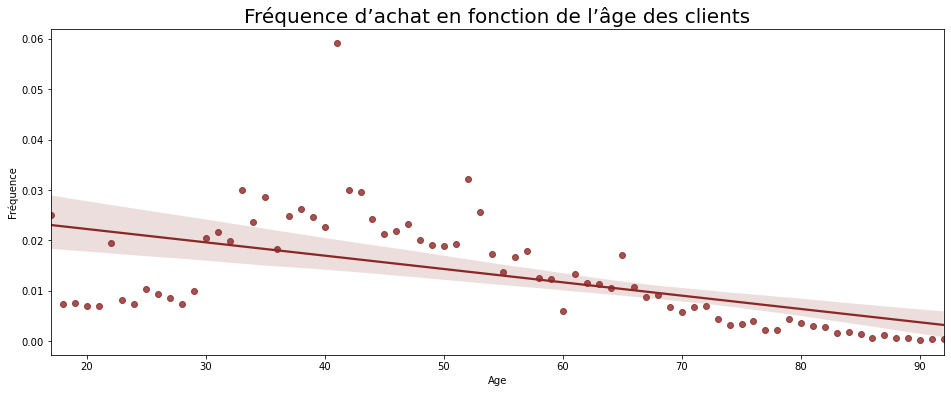

In [110]:
plt.figure(figsize=(16,6))
sb.regplot(x=freq.index, y=freq["Fréquence"], color="#8C2727")
plt.title("Fréquence d’achat en fonction de l’âge des clients", fontsize=20)
plt.savefig('Fréquence d’achat en fonction de l\'âge des clients.png',transparent=True,dpi=300)
plt.show()

Jusqu'à 29 ans la fréquence d'achat est stable , a partir de 33 ans la fréquence des achats diminue a mesure que l'age augmente.

### Le lien entre l’âge des clients et la taille du panier moyen

Le panier moyen est obtenu en divisant le chiffre d'affaires total par le nombre de commandes total, sur une période donnée.</p>
*Panier moyen = Chiffre d’affaires généré / Nombre total de commandes traitées*

In [111]:
ap = df.groupby('age')[['price']].sum() #obtenir le chiffre d'affaires par age
ase = df.groupby('age')[['session_id']].nunique() #obtenir le nombre de commande passée par age

pm = pd.merge(ap, ase, how="inner", on="age")
pm['Panier_moyen']= round((pm.price/pm.session_id),2) #création d'une colonne panier moyer en divisant le CA par le nombre de commande
pm = pm.rename(columns={"price": "CA","session_id":"nb_commandes"})
pm.index.name = 'Age'
pm 

,CA,nb_commandes,Panier_moyen
Age,,,
17,609013.69,8594,70.86
18,178195.78,2567,69.42
19,184177.35,2604,70.73
20,178497.70,2431,73.43
21,165007.98,2421,68.16
...,...,...,...
88,5254.35,233,22.55
89,5043.19,206,24.48
90,2815.45,96,29.33


In [112]:
# Le test de D'Agostino ou test du K²(k is the z-score returned by kurtosistest) de D'Agostino

data = pm['Panier_moyen']
stat, p = normaltest(data)
print('stat=%.3f, p-value=%.3f' % (stat, p))
if p > 0.05:
    print('H0 : La distribution observée est compatible avec une distribution théorique normale')
else:
    print('H1 : La distribution observée n\'est pas compatible avec la loi normale')

stat=24.617, p-value=0.000
H1 : La distribution observée n'est pas compatible avec la loi normale


In [113]:
# Test de Kolmogorov-Smirnov 

data = pm['Panier_moyen']
stat, p = ks_2samp(data,list(np.random.normal(np.mean(data), np.std(data), 1000)))
print('stat=%.3f, p-value=%.3f' % (stat, p))
if p > 0.05:
    print('H0 : La distribution observée est compatible avec une distribution théorique normale')
else:
    print('H1 : La distribution observée n\'est pas compatible avec la loi normale')

stat=0.348, p-value=0.000
H1 : La distribution observée n'est pas compatible avec la loi normale


Définition des hypothèses:  
   - H0: les deux variables (age et panier moyen) sont indépendantes.
   - H1: il existe une dépendance entre l'age et la taille du panier moyen.

Définition des hypothèses:  
  - H0 : Il n’y a pas de lien entre les deux variables
  - H1 : Il y a un lien entre les deux variables

In [114]:
#Test corrélation de Spearman

data1 = pm.index
data2 = pm['Panier_moyen']
stat, p = spearmanr(data1, data2)
print('Coefficient de corrélation=%.3f, p-value=%.3f' % (stat, p))
if p > 0.05:
    print('H0 : Il n’y a pas de lien entre les deux variables')
else:
    print('H1 : Il y a probablement un lien entre les deux variables')

Coefficient de corrélation=-0.761, p-value=0.000
H1 : Il y a probablement un lien entre les deux variables


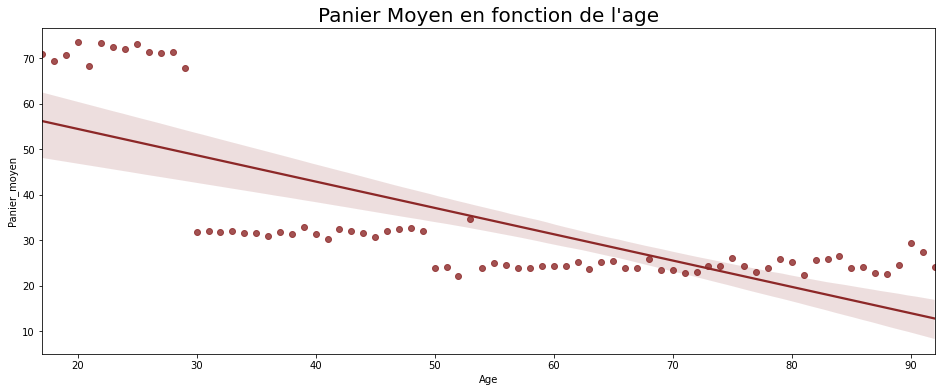

In [115]:
plt.figure(figsize=(16,6))
sb.regplot(x=pm.index, y=pm["Panier_moyen"], color="#8C2727")
plt.title("Panier Moyen en fonction de l\'age",fontsize=20)
plt.savefig('Panier Moyen en fonction de l\'age.png',transparent=True,dpi=300)

plt.show()

On peut indentifier 3 groupes :</p>
 - un panier moyen autour de 70€ pour les 17-30 ans
 - un panier moyen autour de 30€ pour les 30-50 ans
 - un panier moyen autour de 20€ pour les 50ans et +

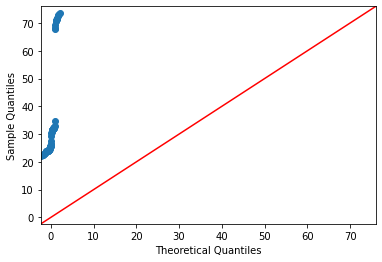

In [116]:
PM = pm['Panier_moyen']
fig = qqplot(PM,line='45')

plt.show()

In [117]:
# D’Agostino’s K^2 Test

data = pm['Panier_moyen']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=24.617, p=0.000
Probably not Gaussian


In [118]:
# Example of the Anderson-Darling Normality Test

data = pm['Panier_moyen']
result = anderson(data)
print('stat=%.3f' % (result.statistic))
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('Probably Gaussian at the %.1f%% level' % (sl))
    else:
        print('Probably not Gaussian at the %.1f%% level' % (sl))

stat=12.416
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


In [119]:
# Test de Kolmogorov-Smirnov 

data = pm['Panier_moyen']
stat, p = ks_2samp(data,list(np.random.normal(np.mean(data), np.std(data), 1000)))
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.351, p=0.000
Probably not Gaussian


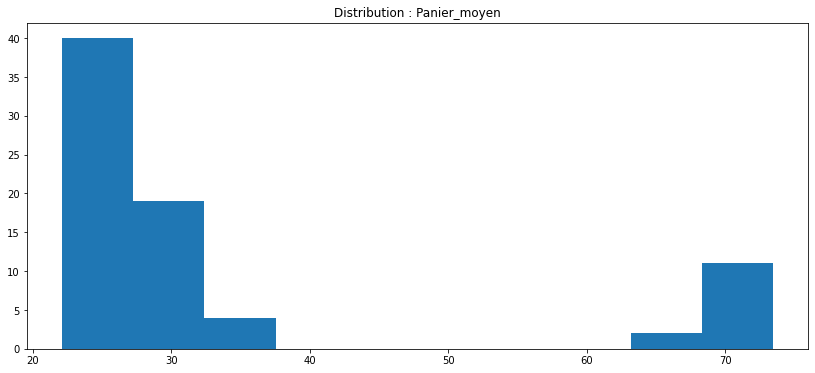

In [120]:
plt.figure(figsize=(14,6))
plt.hist(data)
plt.title("Distribution : Panier_moyen")
plt.show()

### Lien entre le genre d’un client et les catégories des livres achetés.

Définition des hypothèses:  
   - H0: les deux variables (sex et catégorie de livre achetés) sont indépendantes.
   - H1: il existe une dépendance entre le genre d’un client et les catégories des livres achetés.

Définition des hypothèses:  
  - H0 : Il n’y a pas de lien entre les deux variables
  - H1 : Il y a un lien entre les deux variables

In [121]:
# Création du tableau de contingence de nos deux variables
cont_2 = pd.crosstab(df["categ"],df["sex"],margins=True)
cont_2

sex,f,m,All
categ,,,
0,206103,209356,415459
1,114899,112270,227169
2,17283,19200,36483
All,338285,340826,679111


[scipy.stats.chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

Le khi-2 (Chi2 ou  χ² ) est un test d’indépendance pour savoir si nos deux variables qualitatives sont corrélées ou non.

In [122]:
chi2, p, dof, exp = chi2_contingency(cont_2)
print('chi2=%.3f, p=%.3f' % (chi2, p))
if p > 0.05 :
    print('H0 : Il n’y a pas de lien entre les deux variables')
    print('Étant donné que la P-Value est supérieure au niveau de signification alpha=0.05, on ne peut pas rejeter H0')
    print('le risque de rejeter H0 alors qu\'elle est vraie est de',round(p*100,3),'%')
else:
    print('H1 : Il y a probablement un lien entre les deux variables')
    print('Étant donné que la P-Value est inférieure au niveau de signification alpha=0.05, on doit rejeter H0 et retenir H1')
    print('le risque de rejeter H0 alors qu\'elle est vraie est de',round(p*100,3),'%')

chi2=147.119, p=0.000
H1 : Il y a probablement un lien entre les deux variables
Étant donné que la P-Value est inférieure au niveau de signification alpha=0.05, on doit rejeter H0 et retenir H1
le risque de rejeter H0 alors qu'elle est vraie est de 0.0 %


Test de chi2 sur 2 variables variables qualitatives => Tests paramétriques

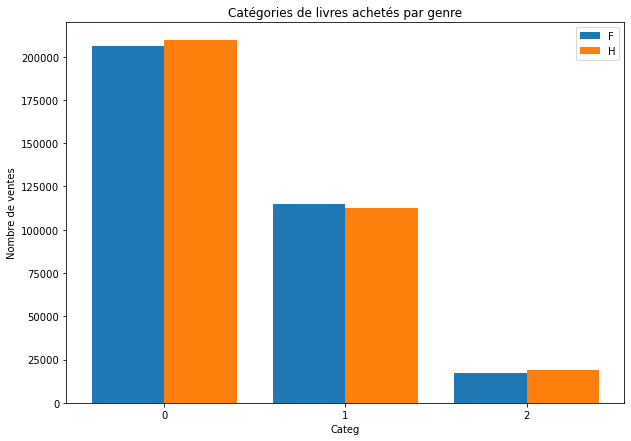

In [123]:
plt.figure(figsize=(10,7))

Categ = ['0','1','2']
F = [206103,114899,17283]
H = [209356,112270,19200]
  
X_axis = np.arange(len(Categ))
  
plt.bar(X_axis - 0.2, F, 0.4, label = 'F')
plt.bar(X_axis + 0.2, H, 0.4, label = 'H')
  
plt.xticks(X_axis, Categ)
plt.xlabel("Categ")
plt.ylabel("Nombre de ventes")
plt.title("Catégories de livres achetés par genre")
plt.legend()
plt.savefig('chi2.png',transparent=True,dpi=300)
plt.show()

## Probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159.

In [124]:
tu=transaction['client_id'].nunique()# ne garder que les clients uniques
print("Il y a ",tu,"clients uniques")

#Calcul de P(A) la probabilité qu'un client achete la référence 2_159

ta = transaction.loc[transaction['id_prod'] == "2_159", :]
PA = ta['client_id'].nunique()
print(PA,"clients ont acheté la référence 2_159")

print("La probabilité qu’un client achète la référence 2_159 est de : ",(PA/tu)*100,"%")

#Calcul de P(B) la probabilité qu'un client achete la référence 0_525

tb = transaction.loc[transaction['id_prod'] == "0_525", :]
PB = tb['client_id'].nunique()
print(PB,"clients ont acheté la référence 0_525")
print("La probabilité qu’un client achète la référence 0_525 est de : ",(PB/tu)*100,"%")


print("La probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159 est de : ",round(PB/PA,4)*100,"%")

Il y a  8600 clients uniques
530 clients ont acheté la référence 2_159
La probabilité qu’un client achète la référence 2_159 est de :  6.162790697674419 %
459 clients ont acheté la référence 0_525
La probabilité qu’un client achète la référence 0_525 est de :  5.337209302325582 %
La probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159 est de :  86.6 %
